# Imports

In [1]:
import sys
sys.path.append('..')

import os
import json
from time import time
import numpy as np
from tqdm import tqdm

import theano
import theano.tensor as T
from theano.sandbox.cuda.dnn import dnn_conv

from PIL import Image

Using gpu device 0: GeForce GTX 780 Ti (CNMeM is disabled, CuDNN 4007)


N.B. The code from the following imports is lifted from the original [dcgan project](https://github.com/Newmu/dcgan_code)

In [2]:
from lib import activations
from lib import updates
from lib import inits
from lib.rng import py_rng, np_rng
from lib.ops import batchnorm, conv_cond_concat, deconv, dropout, l2normalize
from lib.metrics import nnc_score, nnd_score
from lib.theano_utils import floatX, sharedX
from lib.data_utils import OneHot, shuffle, iter_data, center_crop, patch

In [3]:
from fuel.datasets.hdf5 import H5PYDataset
from fuel.schemes import ShuffledScheme, SequentialScheme
from fuel.streams import DataStream

# Data Stuff

In [4]:
import h5py
try:
    hf["target"].shape
except:
    hf = h5py.File('faces.hdf5','r+')
num_samples = hf["input"].shape[0]

print "number of samples in dataset : %i" %num_samples

number of samples in dataset : 201728


In [5]:
split_dict = {
     'train': {'input': (2000, num_samples), 'target': (2000, num_samples)},
     'test': {'input': (0, 1000), 'target': (0, 1000)},
     'val': {'input': (1000, 2000), 'target': (1000, 2000)}
}

hf.attrs['split'] = H5PYDataset.create_split_array(split_dict)
train_set = H5PYDataset('faces.hdf5', which_sets=('train',))
test_set = H5PYDataset('faces.hdf5', which_sets=('test',))
val_set = H5PYDataset('faces.hdf5', which_sets=('val',))

#batch_size = 128
batch_size = 12
#TODO : use shuffledscheme instead?  Seems slower, might have screwed up the chunksize in the HDF5 files?

tr_scheme = SequentialScheme(examples=train_set.num_examples, batch_size=batch_size)
tr_stream = DataStream(train_set, iteration_scheme=tr_scheme)

val_scheme = SequentialScheme(examples=val_set.num_examples, batch_size=batch_size)
val_stream = DataStream(val_set, iteration_scheme=val_scheme)

test_scheme = SequentialScheme(examples=test_set.num_examples, batch_size=batch_size)
test_stream = DataStream(test_set, iteration_scheme=test_scheme)

## Check data looks sensible

EXAMPLE TARGET IMAGE:


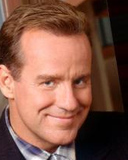

In [6]:
for x_train, x_target in tr_stream.get_epoch_iterator():
    break
print "EXAMPLE TARGET IMAGE:"

Image.fromarray(x_target[3].astype(np.uint8))

EXAMPLE INPUT IMAGE:


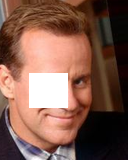

In [7]:
print "EXAMPLE INPUT IMAGE:"
Image.fromarray(x_train[3].astype(np.uint8))

# Setup Neural Network

In [8]:
def target_transform(X):
    return floatX(X).transpose(0, 3, 1, 2)/127.5 - 1.

def input_transform(X):
    return target_transform(X)

In [9]:
l2 = 1e-5         # l2 weight decay
nvis = 196        # # of samples to visualize during training
b1 = 0.5          # momentum term of adam
nc = 3            # # of channels in image
#nbatch = 128      # # of examples in batch
nbatch = 12      # # of examples in batch
npx = 64          # # of pixels width/height of images

nx = npx*npx*nc   # # of dimensions in X
niter = 1000        # # of iter at starting learning rate
niter_decay = 30   # # of iter to linearly decay learning rate to zero
lr = 0.0002       # initial learning rate for adam
ntrain = 25000   # # of examples to train on

relu = activations.Rectify()
sigmoid = activations.Sigmoid()
lrelu = activations.LeakyRectify()
tanh = activations.Tanh()
bce = T.nnet.binary_crossentropy

def mse(x,y):
    return T.sum(T.pow(x-y,2), axis = 1)

gifn = inits.Normal(scale=0.02)
difn = inits.Normal(scale=0.02)
sigma_ifn = inits.Normal(loc = -100., scale=0.02)
gain_ifn = inits.Normal(loc=1., scale=0.02)
bias_ifn = inits.Constant(c=0.)


The following methods are to help adjust the sizes of the convolutional layers in the generator and discriminator, which is very fiddly to do otherwise.  The (overloaded) method make_conv_set can be used to create both the conv 
and deconv sets of layers.  Note that the 'size' of the images is the size of the shortest side (32 in the input set, 128 in the target set).  Only use powers of 2 here.

In [10]:
def make_conv_layer(X, input_size, output_size, input_filters, 
                    output_filters, name, index,
                    weights = None, filter_sz = 5):
    
    is_deconv = output_size >= input_size

    w_size = (input_filters, output_filters, filter_sz, filter_sz) \
            if is_deconv else (output_filters, input_filters, filter_sz, filter_sz)
    
    if weights is None:
        w = gifn(w_size, '%sw%i' %(name, index))
        g = gain_ifn((output_filters), '%sg%i' %(name, index))
        b = bias_ifn((output_filters), '%sb%i' %(name, index))
    else:
        w,g,b = weights
        
    
    conv_method = deconv if is_deconv else dnn_conv
    activation = relu if is_deconv else lrelu
    
    sub = output_size / input_size if is_deconv else input_size / output_size
    
    if filter_sz == 3:
        bm = 1
    else:
        bm = 2
    
    layer = activation(batchnorm(conv_method(X, w, subsample=(sub, sub), border_mode=(bm, bm)), g=g, b=b))
    
    return layer, [w,g,b]

def make_conv_set(input, layer_sizes, num_filters, name, weights = None, filter_szs = None):
    assert(len(layer_sizes) == len(num_filters))
    
    vars_ = []
    layers_ = []
    current_layer = input
    
    for i in range(len(layer_sizes) - 1):
        input_size = layer_sizes[i]
        output_size = layer_sizes[i + 1]
        input_filters = num_filters[i]
        output_filters = num_filters[i + 1]
        
        if weights is not None:
            this_wts = weights[i * 3 : i * 3 + 3]
        else:
            this_wts = None
            
        if filter_szs != None:
            filter_sz = filter_szs[i]
        else:
            filter_sz = 5
        
        layer, new_vars = make_conv_layer(current_layer, input_size, output_size, 
                                          input_filters, output_filters, name, i, 
                                          weights = this_wts, filter_sz = filter_sz)
        
        vars_ += new_vars
        layers_ += [layer]
        current_layer = layer
        
    return current_layer, vars_, layers_

In [12]:
import pickle
#Use code below if you want use a saved model
'''
[e_params, g_params, d_params] = pickle.load( open( "models/autoencoder_100epoch/faces_dcgan_denoising_64epoch_100encoding.pkl", "rb" ) )
gwx = g_params[-1]
dwy = d_params[-1]

# inputs
X = T.tensor4()

## encode layer
e_layer_sizes = [128, 64, 32, 16, 8]
e_filter_sizes = [3, 256, 256, 512, 1024]

eX, e_params, e_layers = make_conv_set(X, e_layer_sizes, e_filter_sizes, "e", weights=e_params)

## generative layer
g_layer_sizes = [8, 16, 32, 64, 128]
g_num_filters = [1024, 512, 256, 256, 128]


g_out, g_params, g_layers = make_conv_set(eX, g_layer_sizes, g_num_filters, "g", weights=g_params)
g_params += [gwx]
gX = tanh(deconv(g_out, gwx, subsample=(1, 1), border_mode=(2, 2)))


## discrim layer(s)

df1 = 128
d_layer_sizes = [128, 64, 32, 16, 8]
d_filter_sizes = [3, df1, 2 * df1, 4 * df1, 8 * df1]

def discrim(input, name, weights=None):
    d_out, disc_params, d_layers = make_conv_set(input, d_layer_sizes, d_filter_sizes, name, weights = weights)
    d_flat = T.flatten(d_out, 2)
    
    disc_params += [dwy]
    y = sigmoid(T.dot(d_flat, dwy))
    
    return y, disc_params, d_layers

# target outputs
target = T.tensor4()

p_real, d_params, d_layers = discrim(target, "d", weights=d_params)
#we need to make sure the p_gen params are the same as the p_real params
p_gen , d_params2, d_layers = discrim(gX, "d", weights=d_params)

'''


#Use code below if you are training a model from scratch

# inputs
X = T.tensor4()

## encode layer
e_layer_sizes = [128, 64, 32, 16, 8]
e_filter_sizes = [3, 256, 256, 512, 1024]

eX, e_params, e_layers = make_conv_set(X, e_layer_sizes, e_filter_sizes, "e")

## generative layer
g_layer_sizes = [8, 16, 32, 64, 128]
g_num_filters = [1024, 512, 256, 256, 128]


g_out, g_params, g_layers = make_conv_set(eX, g_layer_sizes, g_num_filters, "g")
gwx = gifn((128, nc, 5, 5), 'gwx')
g_params += [gwx]
gX = tanh(deconv(g_out, gwx, subsample=(1, 1), border_mode=(2, 2)))


## discrim layer(s)

df1 = 128
d_layer_sizes = [128, 64, 32, 16, 8]
d_filter_sizes = [3, df1, 2 * df1, 4 * df1, 8 * df1]

dwy = difn((df1 * 8 * 10 * 8, 1), 'dwy')

def discrim(input, name, weights=None):
    d_out, disc_params, d_layers = make_conv_set(input, d_layer_sizes, d_filter_sizes, name, weights = weights)
    d_flat = T.flatten(d_out, 2)
    
    disc_params += [dwy]
    y = sigmoid(T.dot(d_flat, dwy))
    
    return y, disc_params, d_layers

# target outputs
target = T.tensor4()

p_real, d_params, d_layers = discrim(target, "d")
#we need to make sure the p_gen params are the same as the p_real params
p_gen , d_params2, d_layers = discrim(gX, "d")

In [13]:
# test everything working so far (errors are most likely size mismatches)
f = theano.function([X], p_gen)
f(input_transform(x_train)).shape

(12, 1)

Next we set up the various cost functions we need

In [14]:
from theano.tensor.signal.downsample import max_pool_2d

## GAN costs
d_cost_real = bce(p_real, T.ones(p_real.shape)).mean()
d_cost_gen = bce(p_gen, T.zeros(p_gen.shape)).mean()
g_cost_d = bce(p_gen, T.ones(p_gen.shape)).mean()

## MSE encoding cost is done on an (averaged) downscaling of the image
target_pool = max_pool_2d(target, (4,4), mode="average_exc_pad",ignore_border=True)
target_flat = T.flatten(target_pool, 2)
gX_pool = max_pool_2d(gX, (4,4), mode="average_exc_pad",ignore_border=True)
gX_flat = T.flatten(gX_pool,2)
enc_cost = mse(gX_flat, target_flat).mean() 

## MSE encoding without max pooling
'''
target_flat = T.flatten(target, 2)
gX_flat = T.flatten(gX,2)
enc_cost = mse(gX_flat, target_flat).mean() 
'''

## generator cost is a linear combination of the discrim cost plus the MSE enocding cost
d_cost = d_cost_real + d_cost_gen

#To change the weight of MSE, change the denominator.  ex. enc_cost/5 weights MSE much less that enc_cost/1
g_cost = g_cost_d + enc_cost / 1  

## N.B. e_cost and e_updates will only try and minimise MSE loss on the autoencoder (for debugging)
e_cost = enc_cost

cost = [g_cost_d, d_cost_real, enc_cost]

elrt = sharedX(0.002)
lrt = sharedX(lr)
d_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
g_updater = updates.Adam(lr=lrt, b1=b1, regularizer=updates.Regularizer(l2=l2))
e_updater = updates.Adam(lr=elrt, b1=b1, regularizer=updates.Regularizer(l2=l2))

d_updates = d_updater(d_params, d_cost)
g_updates = g_updater(e_params + g_params, g_cost)
e_updates = e_updater(e_params, e_cost)

/home/ave/projects/dcgan-autoencoder/theano_env/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [15]:
print 'COMPILING'
t = time()
_train_g = theano.function([X, target], cost, updates=g_updates)
_train_d = theano.function([X, target], cost, updates=d_updates)
_train_e = theano.function([X, target], cost, updates=e_updates)
_get_cost = theano.function([X, target], cost)
print '%.2f seconds to compile theano functions'%(time()-t)

COMPILING
37.25 seconds to compile theano functions


# Training code

Code for generating the images every 100 batches or so.

In [16]:
img_dir = "gen_images/"

if not os.path.exists(img_dir):
    os.makedirs(img_dir)

ae_encode = theano.function([X, target], [gX, target])

def inverse(X):
    X_pred = (X.transpose(0, 2, 3, 1) + 1) * 127.5
    X_pred = np.rint(X_pred).astype(int)
    X_pred = np.clip(X_pred, a_min = 0, a_max = 255)
    return X_pred.astype('uint8')


def save_sample_pictures():
    for te_train, te_target in test_stream.get_epoch_iterator():
        break
    te_out, te_ta = ae_encode(input_transform(te_train), target_transform(te_target))
    te_reshape = inverse(te_out)
    te_target_reshape = inverse(te_ta)

    new_size = (128 * 6, 160 * 12)
    new_im = Image.new('RGB', new_size)
    r = np.random.choice(12, 24, replace=True).reshape(2,12)
    for i in range(2):
        for j in range(12):
            index =  r[i][j]
            
            target_im = Image.fromarray(te_target_reshape[index])
            train_im = Image.fromarray(te_train[index].astype(np.uint8))
            im = Image.fromarray(te_reshape[index])
            
            new_im.paste(target_im, (128 * i * 3, 160 * j))
            new_im.paste(train_im, (128 * (i * 3 + 1), 160 * j))
            new_im.paste(im, (128 * (i * 3 + 2), 160 * j))
    img_loc = "gen_images/%i.png" %int(time())     
    print "saving images to %s" %img_loc
    new_im.save(img_loc)

#saves output for all testing images.  This may take a couple of minutes to run.
def save_all_pictures():
    counter = 0
    for te_train, te_target in test_stream.get_epoch_iterator():
        te_out, te_ta = ae_encode(input_transform(te_train), target_transform(te_target))
        te_reshape = inverse(te_out)
        te_target_reshape = inverse(te_ta)

        new_size = (128 * 3, 160 * 12)
        new_im = Image.new('RGB', new_size)
        r = [range(12),range(12)]
        for i in range(1):
            for j in range(12):
                index =  r[i][j]
                try:
                    target_im = Image.fromarray(te_target_reshape[index])
                    train_im = Image.fromarray(te_train[index].astype(np.uint8))
                    im = Image.fromarray(te_reshape[index])

                    new_im.paste(target_im, (128 * i * 3, 160 * j))
                    new_im.paste(train_im, (128 * (i * 3 + 1), 160 * j))
                    new_im.paste(im, (128 * (i * 3 + 2), 160 * j))
                except:
                    print "Eror with training image"
        img_loc = "gen_images/test_result_%i.png" %counter     
        print "saving images to %s" %img_loc
        new_im.save(img_loc)
        counter+=1

#save_all_pictures()        
save_sample_pictures()

saving images to gen_images/1462216894.png


In [17]:
def mn(l):
    if sum(l) == 0:
        return 0
    return sum(l) / len(l)

## TODO : nicer way of coding these means?

def get_test_errors():
    print "getting test error"
    g_costs = []
    d_costs = []
    e_costs = []
    k_costs = []
    for i in range(20):
        try:
            x_train, x_target  = te_iterator.next()
        except:
            te_iterator = val_stream.get_epoch_iterator()
            x_train, x_target  = te_iterator.next()
        x = input_transform(x_train)
        t = target_transform(x_target)
        cost = _get_cost(x,t)
        g_cost, d_cost, enc_cost = cost
        g_costs.append(g_cost)
        d_costs.append(d_cost)
        e_costs.append(enc_cost)
        
    s= " ,".join(["test errors :", str(mn(g_costs)), str(mn(d_costs)), str(mn(e_costs))])
    return s


# Train Model

Finally, we come to the actual training of the model.  This code can be keyboard interrupted, and the weights will be stored in memory, allowing us to stop, adjust and restart the training (this is how I got the model to train).  For advice on training see the blog post at (#TODO)

In [18]:
iterator = tr_stream.get_epoch_iterator()

# you may wish to reset the learning rate to something of your choosing if you feel it is too high/low
lrt = sharedX(lr)

In [19]:
from time import time

n_updates = 0
t = time()

n_epochs = 200

print "STARTING"



for epoch in range(n_epochs):
    
    
    tm = time()

    g_costs = []
    d_costs = []
    e_costs = []
    
    ## TODO : produces pretty ugly output, redo this?
    for i in tqdm(range(num_samples/128)):
        
        try:
            x_train, x_target  = iterator.next()
        except:
            iterator = tr_stream.get_epoch_iterator()
            x_train, x_target  = iterator.next()
        x = input_transform(x_train)
        t = target_transform(x_target)

        
        ## optional - change the criteria for how often we train the generator or discriminator
        if n_updates % 2 == 1:
            cost = _train_g(x,t) 
        else:
            cost = _train_d(x,t)
            
        # optional - only train the generator on MSE cost.  If you want to only train the autoencoder, uncomment the
        #            and comment the cost updates above
        #cost = _train_e(x,t)
        g_cost, d_cost, enc_cost = cost
        g_costs.append(g_cost)
        d_costs.append(d_cost)
        e_costs.append(enc_cost)

        if n_updates % 100 == 0:
            s= " ,".join(["training errors :", str(mn(g_costs)), str(mn(d_costs)), str(mn(e_costs))])
            g_costs = []
            d_costs = []
            e_costs = []
            print get_test_errors()
            print s
            sys.stdout.flush()
            save_sample_pictures()
        n_updates += 1  

    print "epoch %i of %i took %.2f seconds" %(epoch, n_epochs, time() - tm)
    
    ## optional - reduce the learning rate as you go
    #lrt.set_value(floatX(lrt.get_value() * 0.95))
    #print lrt.get_value()
    
    
    sys.stdout.flush()
    
    
    

  0%|          | 0/1576 [00:00<?, ?it/s]

STARTING
getting test error
test errors : ,2.14296965301 ,0.223548676922 ,1381.51607361
training errors : ,0.802732527256 ,0.764227449894 ,1261.70031738


  2%|▏         | 25/1576 [00:18<13:05,  1.97it/s]

saving images to gen_images/1462216909.png


KeyboardInterrupt: 

# Save weights if wanted
You can reuse them by using the weights in the make_conv_set method #TODO - actually try this!

In [ ]:
import pickle

all_params = [e_params, g_params, d_params]

pickle.dump(all_params, open("faces_dcgan_denoising_165epoch_1encoding.pkl", 'w'))